# Atividade 2

Planejamento de Sistemas Elétricos - PPEE

Aluno: Alexandre Soares Altgott

Matrícula: 102100645


## Definição dos Dados do Problema

Usinas Hidrelétricas, termelétricas e dados gerais do sistema

In [5]:
lista_uhe = []

usina = {
    "Nome": "UHE DO MARCATO", # Nome da Usina
    "Vmax": 100.,            # Volume Máximo em hm^3
    "Vmin": 20.,              # Volume Mínimo em hm^3
    "VI": 65.,
    "Prod": 0.95,             # Produtibilidade em MWmed/hm^3
    "Engol": 60.,             # Engolimento Máximo em hm^3
    "Afl": [                  # Cenários de Afluências (linha: Estágio, coluna: cenário)
            [ 23, 16],
            [ 19, 14],
            [ 15, 11]
    ]
}

lista_uhe.append(usina)

#
# Retirar os comentários abaixo para considerar 2 UHEs
#
# usina = {
#    "Nome": "UHE DO VASCAO",
#    "Vmax": 200.,
#    "Vmin": 40.,
#    "VI": 80,
#    "Prod": 0.85,
#    "Engol": 100.,
#    "Afl": [
#            [ 46, 32],
#            [ 38, 28],
#            [ 30, 22]
#    ]
# }
# lista_uhe.append(usina)

usina = {
    "Nome": "GT_1",     # Nome da Usina Térmica 1
    "Capac": 15.,       # Capacidade Máxima de Geração MWMed
    "Custo": 10.        # Custo de Operação $/MWMed
}

lista_ute = []

lista_ute.append(usina)

usina = {
    "Nome": "GT_2",     # Nome da Usina Térmica 2
    "Capac": 10.,       # Capacidade Máxima de Geração MWmed
    "Custo": 25.        # Custo de Operação $/MWMed
}

lista_ute.append(usina)

#
# d_gerais para o caso 1 UHE
#
d_gerais = {
    "CDef": 500.,             # Custo de Déficit $/MWMed
    "Carga": [ 50, 50., 50],  # Lista com carga a ser atendida por estágio
    "Nr_Disc": 9,            # Número de Discretizações
    "Nr_Est": 3,              # Número de Estágios
    "Nr_Cen": 2               # Número de Cenários de Afluências
}

#
# d_gerais para o caso 2 UHE (Comentar o bloco acima e descomentar o bloco abaixo)

# d_gerais = {
#    "CDef": 500.,
#    "Carga": [ 100, 100., 100],
#    "Nr_Disc": 5,
#    "Nr_Est": 3,
#    "Nr_Cen": 2
# }

#
# Cria dicionário de dados com todas as informações do sistema em estudo
#
sistema = {
    "DGer": d_gerais,
    "UHE": lista_uhe,
    "UTE": lista_ute
}


## Modelo de Otimização

Criação de uma Função para o Despacho Hidrotérmico

$Min \hspace{0.5cm} C_1 \cdot gt_1 + C_2 \cdot gt_2 + CDEF \cdot def + 0.01 \cdot vvert + \alpha$

sujeito a:

$ VF = VI + AFL - vtur - vvert $ (Equação de Balanço Hídrico)

$ \rho \cdot vtur + gt_1 + gt_2 + def = CARGA $ (Equação de Atendimento à Demanda)

$ 0 \le vtur \le 60 $

$ 0 \le vvert \le \infty $

$ 0 \le gt_1 \le 15 $

$ 0 \le gt_2 \le 10 $

$ 0 \le def \le \infty $

Na abordagem PDD são resolvidos diversos problemas de otimização de um único estágio com a formulação descrita acima. A função ***despacho_pdd*** tem o objetivo de implementar um PPL (Problema de Programação Linear) para resolver esses problemas de estágio único.


In [2]:
from cvxopt.modeling import variable, solvers
from cvxopt.modeling import op
import numpy as np

#
# Cria função de despacho hidrotérmico
#

def despacho_pdd(sistema, VI, VF, AFL, custofuturo, iest, imprime):

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  #
  # Cria Variáveis de Decisão
  #

  vt = variable(Num_UHE, "Volume Turbinado na Usina")
  vv = variable(Num_UHE, "Volume Vertido na Usina")
  gt = variable(Num_UTE, "Geração na Usina Térmica")
  deficit = variable(1, "Déficit de Energia no Sistema")

  # Construção da Função Objetivo

  fob = 0

  for i, iusi in enumerate(sistema["UTE"]):
    fob += iusi['Custo']*gt[i]

  fob += sistema["DGer"]["CDef"]*deficit[0]

  for i, iusi in enumerate(sistema["UHE"]):
    fob += 0.01*vv[i]

  # Definição das Restrições

  restricoes = []

  # Balanço Hídrico

  for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append( float(VF[i]) == float(VI[i]) + float(AFL[i]) - vt[i] - vv[i])

  # Atendimento à Demanda

  AD = 0

  for i,usi in enumerate(sistema["UHE"]):
    AD += iusi["Prod"]*vt[i]

  for i,usi in enumerate(sistema["UTE"]):
    AD += gt[i]

  AD += deficit[0]

  restricoes.append( AD == sistema["DGer"]["Carga"][iest])

  # Restricoes Canalização

  for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append(vt[i] >= 0)
    restricoes.append(vt[i] <= iusi["Engol"])
    restricoes.append(vv[i] >= 0)

  for i, iusi in enumerate(sistema["UTE"]):
    restricoes.append(gt[i] >= 0)
    restricoes.append(gt[i] <= iusi["Capac"])

  restricoes.append( deficit[0] >= 0)

  #
  # Cria problema de otimização
  #

  problema = op(fob,restricoes)

  #
  # Chama solver GLPK e resolve o problema de otimização linear
  #

  problema.solve('dense','glpk')

  if ( problema.status == 'optimal' ): # Tem água para ir de VI a VF

    #
    # Armazena resultados do problema em um dicionário de dados
    #

    Dger = {
        "Deficit": deficit[0].value()[0],
        "CustoTotal": fob.value()[0] + custofuturo,
        "CustoFut": custofuturo,
        "CMO": restricoes[Num_UHE].multiplier.value[0]
    }

    lista_uhe = []
    for i, iusi in enumerate(sistema["UHE"]):
      resultado = {
          "vf": VF[i],
          "vt": vt[i].value()[0],
          "vv": vv[i].value()[0],
          "cma": restricoes[i].multiplier.value[0]
                  }
      lista_uhe.append(resultado)

    lista_ute = []
    for i, iusi in enumerate(sistema["UTE"]):
      resultado = {
          "gt": gt[i].value()[0]
      }
      lista_ute.append(resultado)

  else: # Não tem água para ir de VI a VF
    Dger = {
        "Deficit": 0,
        "CustoTotal": np.inf,
        "CustoFut": custofuturo,
        "CMO": np.inf
    }
    lista_uhe = []
    lista_ute = []

  resultado = {
      "DGer": Dger,
      "UHE": lista_uhe,
      "UTE": lista_ute
  }

  #
  # Imprime resultados em tela
  #

  if imprime and ( problema.status == 'optmal' ):
    print("Custo Total:", fob.value())

    for i,usi in enumerate(sistema["UHE"]):
      print(vt.name,i,"é",vt[i].value(),"hm3")
      print(vv.name,i,"é",vv[i].value(),"hm3")

    for i,usi in enumerate(sistema["UTE"]):
      print(gt.name,i,"é",gt[i].value(), "MWmed")

    print(deficit.name,"é",deficit[0].value(), "MWmed")

    print("----- x ------ ")

  #
  # Retorna da função exportando os resultados
  #

  return(resultado)


## Programação Dinâmica Determinística (PDD)

O objetivo da função ***pdd*** é implementar o algoritmo da Programação Dinâmica Determinística (PDD).

A saída desta função está é um dicionário exatamente no mesmo formato da função pl_unico, o que facilita a comparação dos resultados obtidos por ambos algoritmos.

In [3]:
from itertools import product, tee
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time

def pdd(sistema, cenario, imprime):

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  #
  # Calcula o tamanho do passo percentual (distância entre cada discretização)
  #

  passo = 100/(sistema["DGer"]["Nr_Disc"]-1)

  #
  # Calcula um iterator com todas as combinações possíveis
  #

  discretizacoes = product(np.arange(0,100+passo,passo), repeat = Num_UHE)

  #
  # Transforma o iterator em uma lista
  #

  discretizacoes = list(discretizacoes)

  #
  # Computa o instante de tempo no qual o processo iterativo iniciou
  #
  t = time.time()

  #
  # Laço ou Loop mais externo de estágios (de trás para frente ou backward)
  #
  arvore = []
  for iest in np.arange(sistema["DGer"]["Nr_Est"],0,-1):

    #
    # Pega cenário de afluencia do estágio
    #

    AFL = []
    for i, iusi in enumerate(sistema["UHE"]):
      AFL.append(iusi["Afl"][iest-1][cenario])

    #
    # Laço ou loop intermediário (percorre todas as discretizações para cada
    # Estágio)
    #
    for disc_atual in discretizacoes:
      #
      # Conforme for a discretização calcula o VI (Volume Inicial) em hm^3
      # para cada UHE
      #
      VI = []
      for i, iusi in enumerate(sistema["UHE"]):
        VI.append(iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*disc_atual[i]/100)

      #
      # Laço ou loop mais interno. Varre todos os cenários para cada discretização
      #
      todos = []
      menor = np.inf
      posicao_menor = 99999
      posicao = 0
      for disc_futura in discretizacoes:
        #
        # Conforme for a discretização futura calcula o VF (Volume Inicial) em hm^3
        # para cada UHE
        #
        VF = []
        for i, iusi in enumerate(sistema["UHE"]):
          VF.append(iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*disc_futura[i]/100)

        #
        # Encontra Custu Futuro associado a disc_futura
        #
        CustoFuturo = 0
        for folha in arvore:
          if ( folha["VI"] == VF ) and ( folha["Est"] == iest):
            CustoFuturo = folha["Dger"]["CustoTotal"]

        #
        # Chama função de despacho hidrotérmico
        #
        resultado = despacho_pdd(sistema,VI, VF, AFL, CustoFuturo, iest-1, imprime = False)
        todos.append([ iest-1, VI, VF, resultado ])
        if ( resultado["DGer"]["CustoTotal"] < menor ):
          menor = resultado["DGer"]["CustoTotal"]
          posicao_menor = posicao
        posicao += 1
      melhor = {
          "Est": todos[posicao_menor][0],
          "VI": todos[posicao_menor][1],
          "VF": todos[posicao_menor][2],
          "Dger": todos[posicao_menor][3]["DGer"],
          "UHE": todos[posicao_menor][3]["UHE"],
          "UTE": todos[posicao_menor][3]["UTE"]
      }
      arvore.append(melhor)
  #
  # Calcula o tempo decorrido desde o início do algoritmo
  #
  print("Tempo decorrido na PDD", time.time() - t)

  tempo = time.time() - t

  #for folha in arvore:
  # print(folha)

  #
  # A parir dos Volumes Iniciais das UHEs, é obtida a estratégia operativa para
  # todo o período de planejamento. Ao mesmo tempo, é preparado o dicionário de
  # dados resultado com o mesmo formato do algoritmo pl_unico desenvolvido na
  # aula anterior
  #

  #
  # A condição inicial deve ser levada para uma das discretizações em cada UHE
  # Por exemplo, se as discretizações são 20hm^3, 60hm^3 e 100hm^3 e o volume
  # inicial da UHE é de 65hm^3, ele deve ser considerado como 60hm^3 pois é a
  # discretização viável mais próxima
  #

  Cond_Inicial = []
  for i, iusi in enumerate(sistema["UHE"]):
    if iusi["VI"] < iusi["Vmax"]:
      disc = np.arange(0,100+passo,passo)
      for iidisc, idisc in enumerate(disc):
        vdisc = iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*idisc/100
        if vdisc > iusi["VI"]:
          Cond_Inicial.append(iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*disc[iidisc-1]/100)
          break
    else:
        Cond_Inicial.append(iusi["Vmax"])


  """ Inicializa listas com as variáveis de decisão que serão preenchidas
  com as informações dos diferentes estágios """

  vf = []
  vt = []
  vv = []
  cma = []
  for i, iusi in enumerate(sistema["UHE"]):
    vf.append([])
    vt.append([])
    vv.append([])
    cma.append([])
  gt = []
  for i, iusi in enumerate(sistema["UTE"]):
    gt.append([])

  cmo = []
  deficit = []
  custo_total = 0.

  #
  # Preenche listas
  #
  for iest in range(0,sistema["DGer"]["Nr_Est"]):
    for folha in arvore:
      if ( folha["Est"] == iest ) and ( folha["VI"] == Cond_Inicial):
        for i in range(Num_UHE):
          vf[i].append(folha["UHE"][i]["vf"])
          vt[i].append(folha["UHE"][i]["vt"])
          vv[i].append(folha["UHE"][i]["vv"])
          cma[i].append(folha["UHE"][i]["cma"])
        for i in range(Num_UTE):
          gt[i].append(folha["UTE"][i]["gt"])
        cmo.append(folha["Dger"]["CMO"])
        deficit.append(folha["Dger"]["Deficit"])
        custo_total += folha["Dger"]["CustoTotal"] - folha["Dger"]["CustoFut"]
        Cond_Inicial = folha["VF"]
        break

  #
  # Monta lista_uhe
  #
  lista_uhe = []
  for i in range(Num_UHE):
    elemento = {
        "vf": vf[i],
        "vt": vt[i],
        "vv": vv[i],
        "cma": cma[i]
    }
    lista_uhe.append(elemento)

  #
  # Monta lista_ute
  #
  lista_ute = []
  for i in range(Num_UTE):
    elemento = {
        "gt": gt[i],
    }
    lista_ute.append(elemento)

  #
  # Preenche dicionário de dados com a saída
  #
  resultado = {
      "DGer": {
          "CustoTotal": custo_total,
          "CMO": cmo,
          "Deficit": deficit,
          "Tempo": tempo
      },
      "UHE": lista_uhe,
      "UTE": lista_ute
  }

  return(resultado)

In [4]:
from cvxopt.modeling import variable, solvers
from cvxopt.modeling import op

def pl_unico(sistema, cenario, imprime):

  #
  # Cria função de despacho hidrotérmico
  #

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  #
  # Cria Variáveis de Decisão Organizadas Matricialmente
  # Exemplo de acesso à variável de decisão de volume final
  # vf[usina][estagio]
  #

  vf = []
  vt = []
  vv = []
  for i,iusi in enumerate(sistema["UHE"]):
    vf.append(variable(sistema["DGer"]["Nr_Est"], "Volume Final na Usina "+iusi["Nome"]))
    vt.append(variable(sistema["DGer"]["Nr_Est"], "Volume Turbinado na Usina "+iusi["Nome"]))
    vv.append(variable(sistema["DGer"]["Nr_Est"], "Volume Vertido na Usina "+iusi["Nome"]))
  gt = []
  for i,iusi in enumerate(sistema["UTE"]):
    gt.append(variable(sistema["DGer"]["Nr_Est"], "Geração na Usina Térmica "+iusi["Nome"]))
  deficit = variable(sistema["DGer"]["Nr_Est"], "Déficit de Energia no Sistema")

  #
  # Construção da Função Objetivo
  #

  fob = 0

  for i_est in range(sistema["DGer"]["Nr_Est"]):
    for i, iusi in enumerate(sistema["UTE"]):
      fob += iusi['Custo']*gt[i][i_est]

    fob += sistema["DGer"]["CDef"]*deficit[i_est]

    for i, iusi in enumerate(sistema["UHE"]):
      fob += 0.01*vv[i][i_est]

  #
  # Definição das Restrições
  #

  restricoes = []

  #
  # Balanço Hídrico
  #

  for i, iusi in enumerate(sistema["UHE"]):
    for i_est in range(sistema["DGer"]["Nr_Est"]):
      if i_est == 0:
        restricoes.append( vf[i][i_est] == float(iusi["VI"]) + float(iusi["Afl"][i_est][cenario]) - vt[i][i_est] - vv[i][i_est])
      else:
        restricoes.append( vf[i][i_est]  ==  vf[i][i_est-1]  + float(iusi["Afl"][i_est][cenario]) - vt[i][i_est] - vv[i][i_est])

  #
  # Atendimento à Demanda
  #

  for i_est in range(sistema["DGer"]["Nr_Est"]):
    AD = 0
    for i,iusi in enumerate(sistema["UHE"]):
      AD += iusi["Prod"]*vt[i][i_est]
    for i,usi in enumerate(sistema["UTE"]):
      AD += gt[i][i_est]
    AD += deficit[i_est]
    restricoes.append( AD == sistema["DGer"]["Carga"][i_est])

  #
  # Restricoes Canalização
  #

  for i_est in range(sistema["DGer"]["Nr_Est"]):
    for i, iusi in enumerate(sistema["UHE"]):
      restricoes.append(vf[i][i_est] >= iusi["Vmin"])
      restricoes.append(vf[i][i_est] <= iusi["Vmax"])
      restricoes.append(vt[i][i_est] >= 0)
      restricoes.append(vt[i][i_est] <= iusi["Engol"])
      restricoes.append(vv[i][i_est] >= 0)
    for i, iusi in enumerate(sistema["UTE"]):
      restricoes.append(gt[i][i_est] >= 0)
      restricoes.append(gt[i][i_est] <= iusi["Capac"])
    restricoes.append(deficit[i_est] >= 0)

  #
  # Cria problema de otimização
  #

  problema = op(fob,restricoes)

  #
  # Chama solver GLPK e resolve o problema de otimização linear
  #

  problema.solve('dense','glpk')

  #
  # Prepara dicionário de dados com resultados
  #

  lista_uhe = []
  for i, iusi in enumerate(sistema["UHE"]):
    pula = i*sistema["DGer"]["Nr_Est"]
    cma = []
    volf = []
    volt = []
    volv = []
    for iest in range(sistema["DGer"]["Nr_Est"]):
      cma.append(restricoes[pula+i_est].multiplier.value[0])
      volf.append(vf[i][iest].value()[0])
      volt.append(vt[i][iest].value()[0])
      volv.append(vv[i][iest].value()[0])
    elemento = {
        "vf": volf,
        "vt": volt,
        "vv": volv,
        "cma": cma
    }
    lista_uhe.append(elemento)

  lista_ute = []
  for i, iusi in enumerate(sistema["UTE"]):
    gerter = []
    for iest in range(sistema["DGer"]["Nr_Est"]):
      gerter.append(gt[i][iest].value()[0])
    elemento = {
        "gt": gerter,
    }
    lista_ute.append(elemento)

  pula = Num_UHE*sistema["DGer"]["Nr_Est"]
  cmo = []
  for i_est in range(sistema["DGer"]["Nr_Est"]):
    cmo.append(restricoes[pula+i_est].multiplier.value[0])

  Dger = {
      "CustoTotal": fob.value()[0],
      "CMO": cmo
  }

  resultado = {
    "DGer": Dger,
    "UHE": lista_uhe,
    "UTE": lista_ute
  }

  #
  # Imprime resultados em tela
  #

  if imprime:
    print("Custo de Operação de Todos os estágios:", fob.value())

    print("Volume Final por UHE em cada Estágio em (hm^3) ")
    for i,usi in enumerate(sistema["UHE"]):
      print(vf[i])
      print(vt[i])
      print(vv[i])

    print("Geração por UTE em cada Estágio em (MWMed)")
    for i,usi in enumerate(sistema["UTE"]):
      print(gt[i])

    print("Déficit de Energia em cada Estágio em (MWMed)")
    print(deficit)

    print("----- x ------ ")

  return(resultado)


## Programa Principal

Utiliza a função pl_unico e plota gráficos

Tempo decorrido na PDD 0.011158943176269531
Tempo decorrido na PDD 0.02466607093811035
Tempo decorrido na PDD 0.03909587860107422
Tempo decorrido na PDD 0.06511449813842773
Tempo decorrido na PDD 0.0955204963684082
Tempo decorrido na PDD 0.13147187232971191
Tempo decorrido na PDD 0.2193155288696289
Tempo decorrido na PDD 0.21447134017944336
Tempo decorrido na PDD 0.3190176486968994
Tempo decorrido na PDD 0.3265500068664551
Tempo decorrido na PDD 0.38794398307800293
Tempo decorrido na PDD 0.5080020427703857
Tempo decorrido na PDD 0.5577516555786133
Tempo decorrido na PDD 0.6589651107788086


Text(0, 0.5, 'Tempo de Execução (s)')

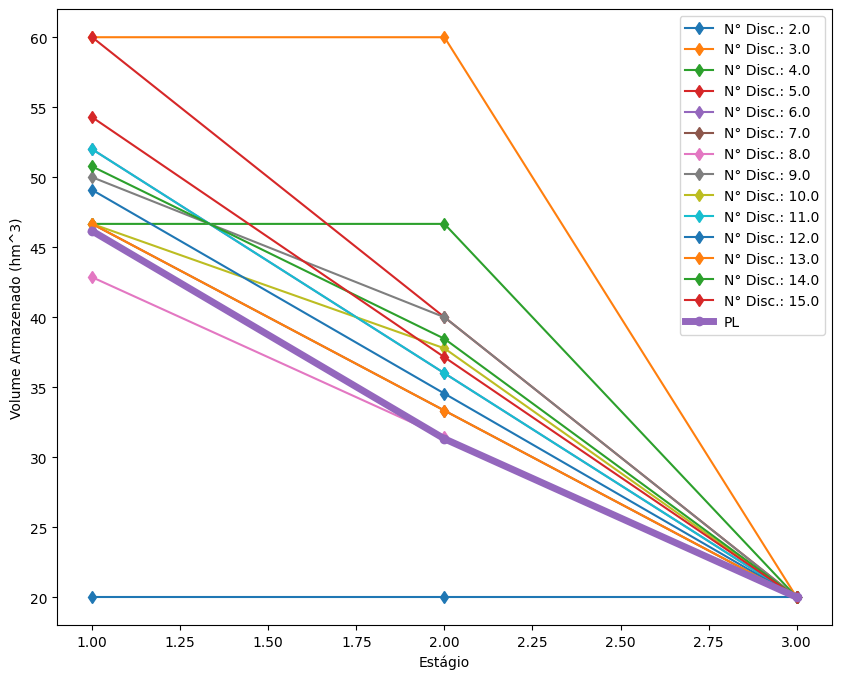

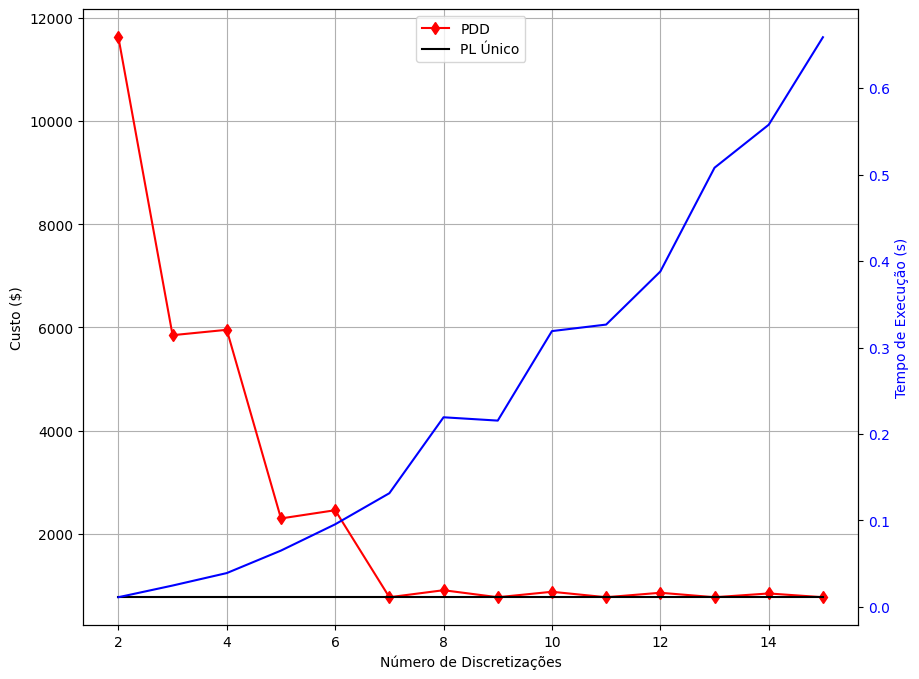

In [26]:
import time

sistema['UHE'][0]['VI'] = 60

#### Para o caso de Duas usinas #####

# sistema['UHE'][1]['VI'] = 90



##### Para fixar as discretizações e variar o volume inicial #####

# sistema['DGer']['Nr_Disc'] = 15

# Custo = []
# CustoPl = []


# vi = np.linspace(20,100,30)




# for i in vi:
#     sistema['UHE'][0]['VI'] = i
#     resultado = pdd(sistema, 0, imprime=False)
#     resultadoPl = pl_unico(sistema, 0, imprime=False)
#     Custo.append(resultado['DGer']['CustoTotal'])
#     CustoPl.append(resultadoPl['DGer']['CustoTotal'])

# plt.figure(figsize=(10,8))
# plt.plot( vi, Custo , marker='d',color='red',label = 'PDD')
# plt.plot( vi, CustoPl , marker='d',color='blue',label = 'PL Único')
# plt.grid()
# plt.xlabel('Volume Inicial (hm^3)')
# plt.ylabel('Custo ($)')
# plt.legend()


##### Para fixar o volume inicial e variar a discretização #####


sistema['UHE'][0]['VI'] = 60

Custo = []
tempo = []

vi = np.linspace(2,15,14)


resultado1 = pl_unico(sistema, 0, imprime=False)


vpl = np.linspace(resultado1['DGer']['CustoTotal'],resultado1['DGer']['CustoTotal'],14)

plt.figure(figsize=(10,8))
plt.xlabel('Estágio')
plt.ylabel('Volume Armazenado (hm^3)')

for i in vi:
    sistema['DGer']['Nr_Disc'] = i
    x = np.arange(0,sistema['DGer']['Nr_Est'],1)
    resultado = pdd(sistema, 0, imprime=False)
    Custo.append(resultado['DGer']['CustoTotal'])
    tempo.append(resultado['DGer']['Tempo'])
    # print(resultado['UHE']['vf'])
    plt.plot(x+1, resultado['UHE'][0]['vf'] , marker='d',label = 'N° Disc.: ' + str(i))
plt.plot(x+1, resultado1['UHE'][0]['vf'] , marker='o', linewidth=5,label = 'PL' )
plt.legend()

plt.figure(figsize=(10,8))
plt.plot( vi, Custo , marker='d',color='red',label = 'PDD')
plt.plot( vi, vpl ,color='black',label = 'PL Único')
plt.xlabel('Número de Discretizações')
plt.ylabel('Custo ($)')
plt.grid()
plt.legend(loc='upper center')
plt.twinx()
plt.plot(vi, tempo, color='blue',label = 'Tempo')
plt.tick_params(labelcolor='blue')

plt.ylabel('Tempo de Execução (s)', color='blue')





## Plota Gráfico das UHEs

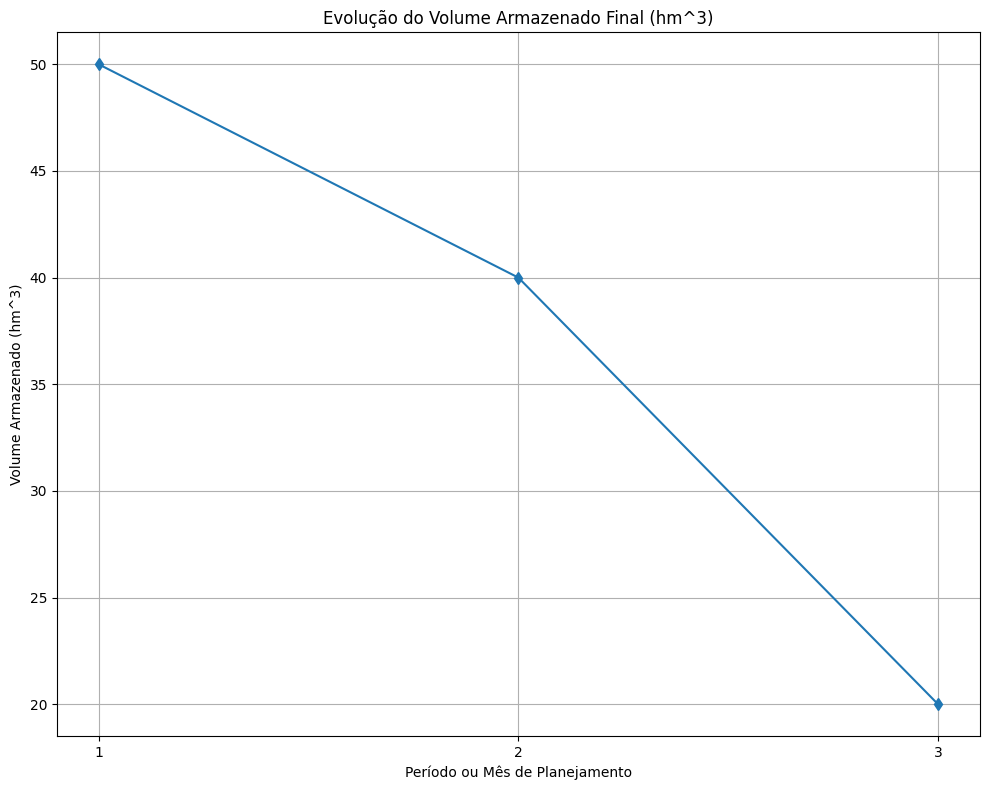

In [10]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0,sistema['DGer']['Nr_Est'],1)
plt.figure(figsize=(10,8))

# %debug

for i, iusi in enumerate(resultado["UHE"]):
  plt.plot(x+1, iusi['vf'] , marker='d')
plt.title('Evolução do Volume Armazenado Final (hm^3)')
plt.xlabel('Período ou Mês de Planejamento')
plt.ylabel('Volume Armazenado (hm^3)')
plt.xticks(x+1)
plt.grid()
plt.tight_layout()
plt.show()

## Plota Gráfico da Geração das UTEs

In [ ]:
import IPython

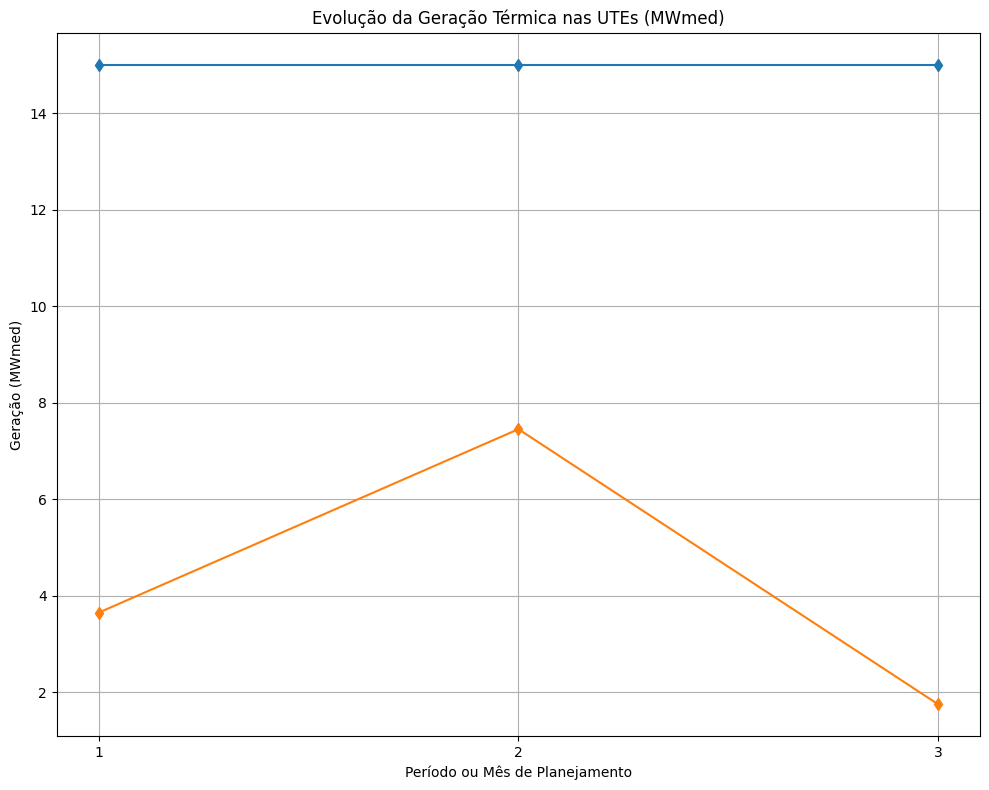

In [11]:
x = np.arange(0,sistema['DGer']['Nr_Est'],1)
plt.figure(figsize=(10,8))

# IPython.embed()

for i, iusi in enumerate(resultado["UTE"]):
  plt.plot(x+1, iusi['gt'] , marker='d')
plt.title('Evolução da Geração Térmica nas UTEs (MWmed)')
plt.xlabel('Período ou Mês de Planejamento')
plt.ylabel('Geração (MWmed)')
plt.xticks(x+1)
plt.grid()
plt.tight_layout()
plt.show()